In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

torch.manual_seed(123)
np.random.seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


 ## Data Preparation

In [2]:
# Create combined dataset class
class CombinedDigitsFashion(torch.utils.data.Dataset):
    def __init__(self, train=True, transform=None):
        # Get MNIST
        digits = datasets.MNIST(root='./data', train=train, download=True, transform=None)
        # Get FashionMNIST
        fashion = datasets.FashionMNIST(root='./data', train=train, download=True, transform=None)

        # Combine data and normalize
        self.images = torch.cat([
            digits.data.float() / 255.0,
            fashion.data.float() / 255.0
        ]).unsqueeze(1)

        # Combine labels (offset fashion by 10)
        self.labels = torch.cat([
            digits.targets,
            fashion.targets + 10
        ])

        # Class names
        self.classes = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            'Top', 'Pants', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot'
        ]

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Create transformations
transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets and loaders
train_data = CombinedDigitsFashion(train=True, transform=transform)
test_data = CombinedDigitsFashion(train=False, transform=transform)

batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


100%|██████████| 9.91M/9.91M [00:10<00:00, 906kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.26MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.1MB/s]


 ## View Sample Images

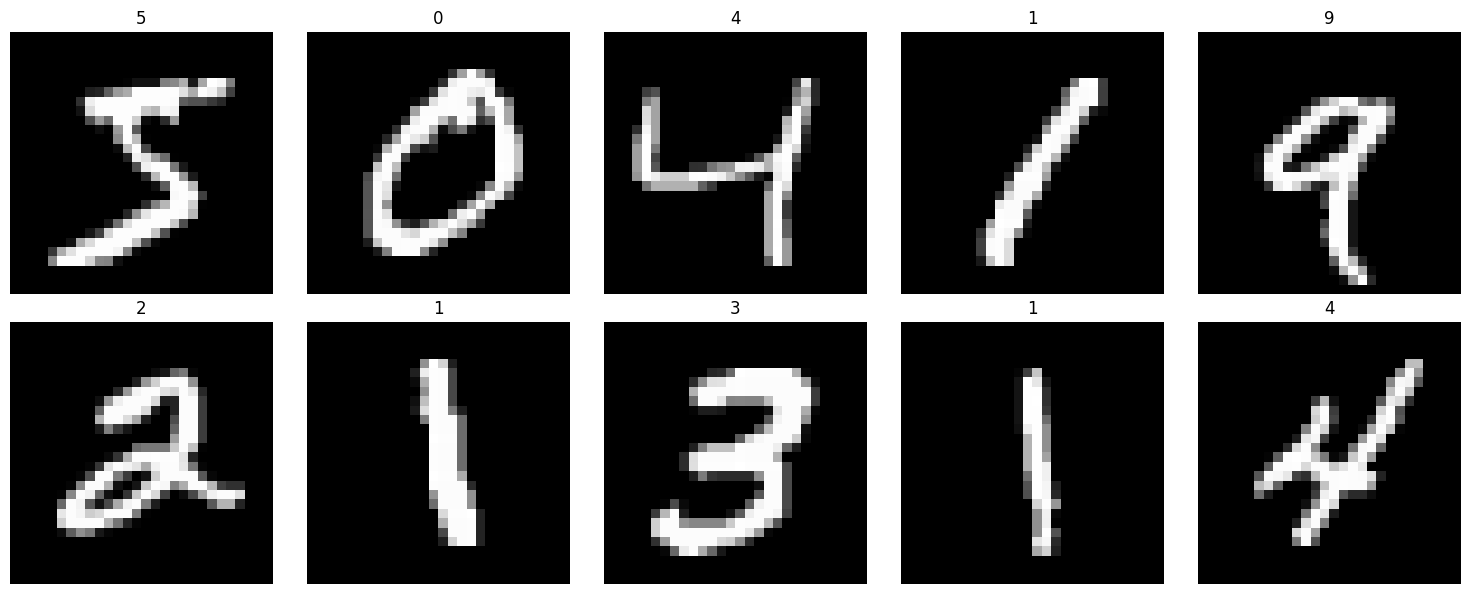

In [3]:
def show_samples(dataset, n=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(n):
        img, label = dataset[i]
        img = img.squeeze()
        img = (img * 0.5) + 0.5  # Denormalize

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"{dataset.classes[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_samples(train_data)


 ## Model Implementation

In [4]:
class MultiHeadLocalAttention(nn.Module):
    """Multi-head attention with local attention window"""
    def __init__(self, dim, n_heads=8, window_size=2, dropout=0.1):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.window_size = window_size
        self.head_dim = dim // n_heads

        # QKV projections
        self.qkv = nn.Linear(dim, 3 * dim)

        # Output projection
        self.proj = nn.Linear(dim, dim)

        # Dropout
        self.attn_drop = nn.Dropout(dropout)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, N, C)
        B, N, C = x.shape

        # Project to queries, keys, values
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, H, N, D)

        # Compute attention with local window
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (B, H, N, N)

        # Create local attention mask
        mask = torch.ones(N, N, device=x.device, dtype=torch.bool)
        for i in range(N):
            left = max(0, i - self.window_size)
            right = min(N - 1, i + self.window_size)
            mask[i, left:right+1] = False

        # Apply mask
        scores.masked_fill_(mask.unsqueeze(0).unsqueeze(0), float('-inf'))

        # Apply softmax and dropout
        attn = F.softmax(scores, dim=-1)
        attn = self.attn_drop(attn)

        # Apply attention to values
        out = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_drop(out)

        return out

class FeedForward(nn.Module):
    """Simple feed-forward network"""
    def __init__(self, dim, hidden_dim=None, dropout=0.1):
        super().__init__()
        hidden_dim = hidden_dim or dim * 4

        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    """Transformer block with local attention"""
    def __init__(self, dim, n_heads, window_size, mlp_ratio=4.0, dropout=0.1):
        super().__init__()

        # Attention
        self.attn = MultiHeadLocalAttention(
            dim=dim,
            n_heads=n_heads,
            window_size=window_size,
            dropout=dropout
        )

        # Feed-forward network
        self.ffn = FeedForward(
            dim=dim,
            hidden_dim=int(dim * mlp_ratio),
            dropout=dropout
        )

        # Layer normalization
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        # Attention with residual connection
        x = x + self.attn(self.norm1(x))

        # Feed-forward with residual connection
        x = x + self.ffn(self.norm2(x))

        return x

class PatchEmbed(nn.Module):
    """Convert image to patch embeddings"""
    def __init__(self, img_size=28, patch_size=4, in_chans=1, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Convolutional patch embedding
        self.proj = nn.Conv2d(
            in_chans, embed_dim,
            kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

class VisionTransformer(nn.Module):
    """Vision Transformer with Local Attention"""
    def __init__(
        self,
        img_size=28,
        patch_size=4,
        in_chans=1,
        n_classes=20,
        embed_dim=192,
        depth=6,
        n_heads=8,
        window_size=2,
        mlp_ratio=4.0,
        dropout=0.1
    ):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim
        )

        # Add class token and positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))

        # Dropout
        self.pos_drop = nn.Dropout(dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim=embed_dim,
                n_heads=n_heads,
                window_size=window_size,
                mlp_ratio=mlp_ratio,
                dropout=dropout
            )
            for _ in range(depth)
        ])

        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, n_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize pos_embed
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        # Initialize all linear layers
        self.apply(self._init_weights_recursive)

    def _init_weights_recursive(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x, labels=None):
        # Get patch embeddings
        x = self.patch_embed(x)  # (B, N, E)

        # Add class token
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat([cls_token, x], dim=1)  # (B, 1+N, E)

        # Add positional embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Get class token output
        x = self.norm(x)[:, 0]  # (B, E)

        # Classification
        logits = self.head(x)  # (B, n_classes)

        # Calculate loss if labels provided
        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)

        return logits, loss

# Initialize model
model = VisionTransformer(
    img_size=28,
    patch_size=4,
    in_chans=1,
    n_classes=20,
    embed_dim=192,
    depth=6,
    n_heads=6,
    window_size=2,
    dropout=0.1
).to(device)

# Print model summary
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model parameters: 2,686,484


 ## Training

In [5]:
# Set up optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training function
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        logits, loss = model(images, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100 * correct / total
        })

    return total_loss / total, 100 * correct / total

# Evaluation function
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        logits, loss = model(images, labels)

        # Track metrics
        total_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, 100 * correct / total

# Create directory for checkpoints
os.makedirs('checkpoints_simple', exist_ok=True)

# Training loop
n_epochs = 5
best_acc = 0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate
    val_loss, val_acc = evaluate(model, test_loader, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Update LR
    scheduler.step()

    # Print metrics
    print(f"  Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}%")
    print(f"  Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}%")
    print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }, 'checkpoints_simple/best_model.pt')
        print(f"  Saved new best model with accuracy: {val_acc:.2f}%")

print(f"Training completed! Best accuracy: {best_acc:.2f}%")


Epoch 1/5


Training: 100%|██████████| 469/469 [00:58<00:00,  8.01it/s, loss=2.27, acc=19.2]


  Train loss: 2.2931, Train acc: 19.23%
  Val loss: 2.1187, Val acc: 25.19%
  LR: 0.001951
  Saved new best model with accuracy: 25.19%
Epoch 2/5


Training: 100%|██████████| 469/469 [00:57<00:00,  8.19it/s, loss=2.08, acc=22.6]


  Train loss: 2.2166, Train acc: 22.60%
  Val loss: 2.0505, Val acc: 27.89%
  LR: 0.001809
  Saved new best model with accuracy: 27.89%
Epoch 3/5


Training: 100%|██████████| 469/469 [00:57<00:00,  8.13it/s, loss=1.95, acc=29.7]


  Train loss: 2.0102, Train acc: 29.70%
  Val loss: 1.8892, Val acc: 33.55%
  LR: 0.001588
  Saved new best model with accuracy: 33.55%
Epoch 4/5


Training: 100%|██████████| 469/469 [00:59<00:00,  7.93it/s, loss=1.77, acc=34.6]


  Train loss: 1.8693, Train acc: 34.56%
  Val loss: 1.7503, Val acc: 40.03%
  LR: 0.001309
  Saved new best model with accuracy: 40.03%
Epoch 5/5


Training: 100%|██████████| 469/469 [00:58<00:00,  8.05it/s, loss=1.72, acc=39.4]


  Train loss: 1.7385, Train acc: 39.42%
  Val loss: 1.6665, Val acc: 42.05%
  LR: 0.001000
  Saved new best model with accuracy: 42.05%
Training completed! Best accuracy: 42.05%


 ## Performance Visualization

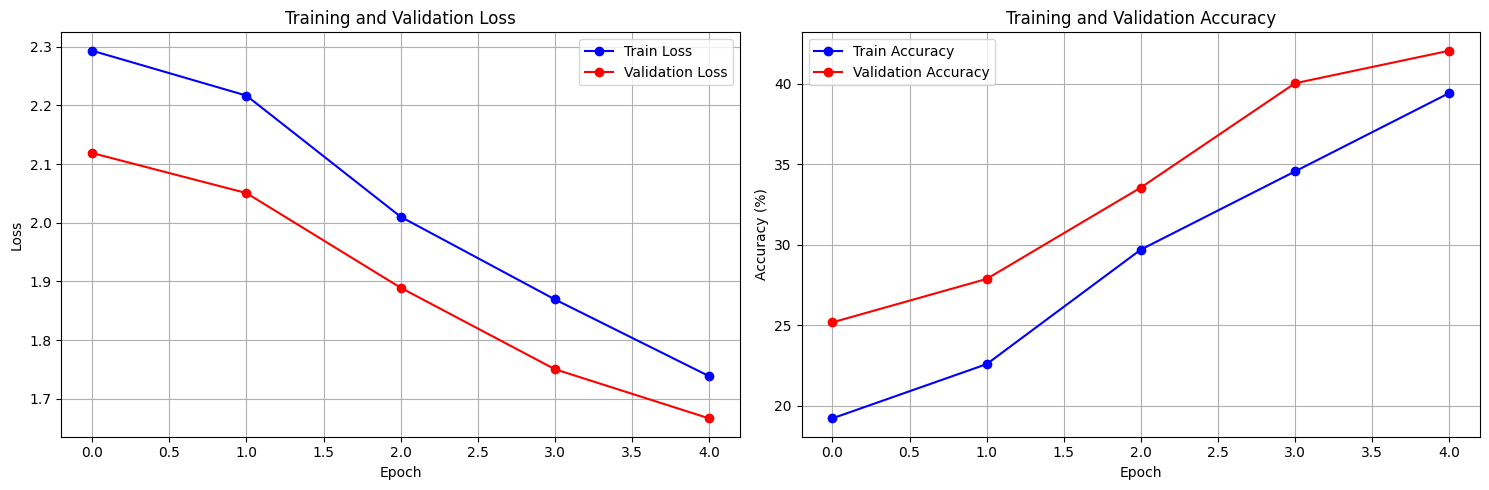

In [6]:
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-o', label='Train Loss')
plt.plot(val_losses, 'r-o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, 'b-o', label='Train Accuracy')
plt.plot(val_accs, 'r-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_performance.png')
plt.show()


 ## Model Analysis

Loaded best model from epoch 5 with validation accuracy: 42.05%
MNIST accuracy: 39.09%
FashionMNIST accuracy: 45.01%


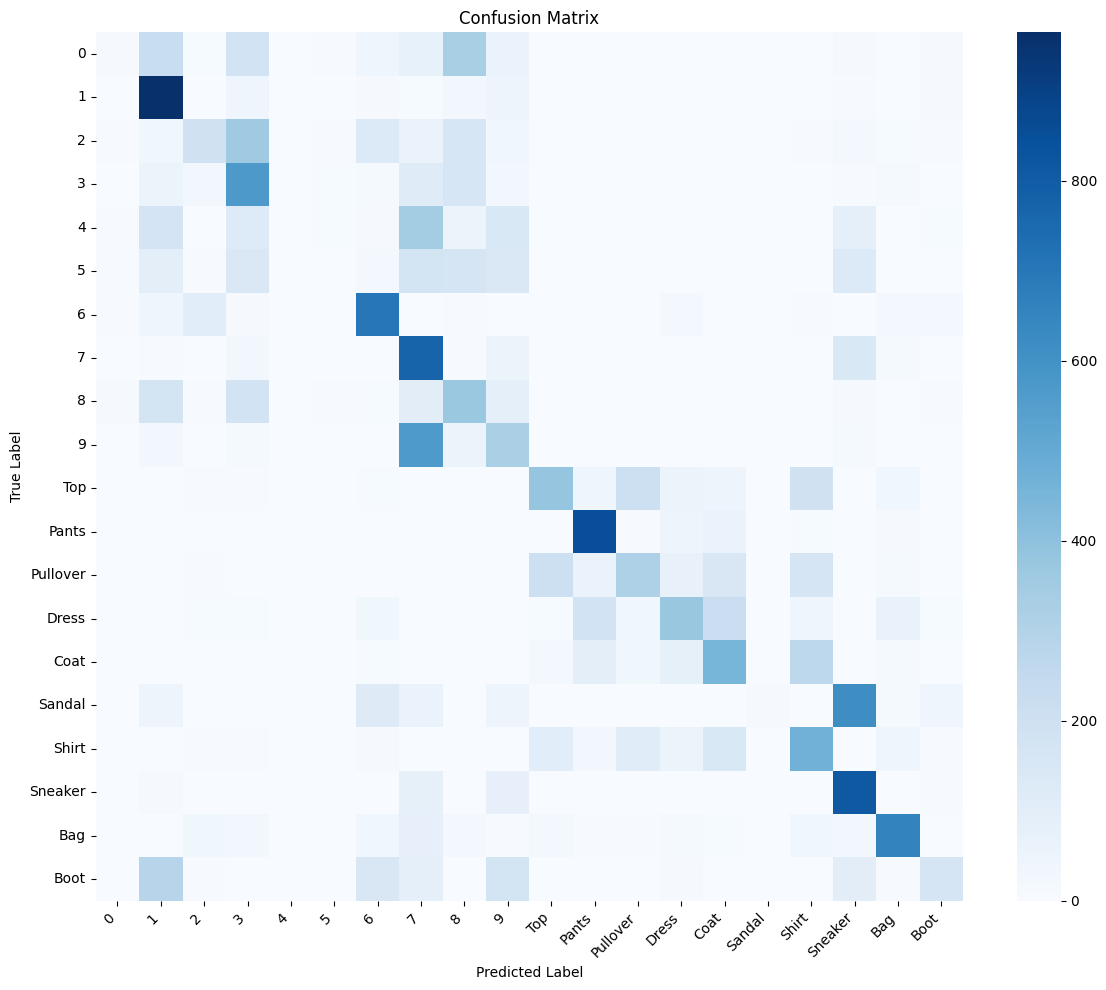

In [7]:
# Load best model
checkpoint = torch.load('checkpoints_simple/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation accuracy: {checkpoint['val_acc']:.2f}%")

# Get predictions for confusion matrix
@torch.no_grad()
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    for images, labels in dataloader:
        images = images.to(device)

        # Forward pass
        logits, _ = model(images)
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions
preds, labels = get_predictions(model, test_loader)

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, preds)

# Calculate accuracy for MNIST and FashionMNIST subsets
mnist_mask = labels < 10
fashion_mask = labels >= 10

mnist_acc = 100 * np.mean(preds[mnist_mask] == labels[mnist_mask])
fashion_acc = 100 * np.mean(preds[fashion_mask] == labels[fashion_mask])

print(f"MNIST accuracy: {mnist_acc:.2f}%")
print(f"FashionMNIST accuracy: {fashion_acc:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d',
            xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()


 ## Performance Comparison

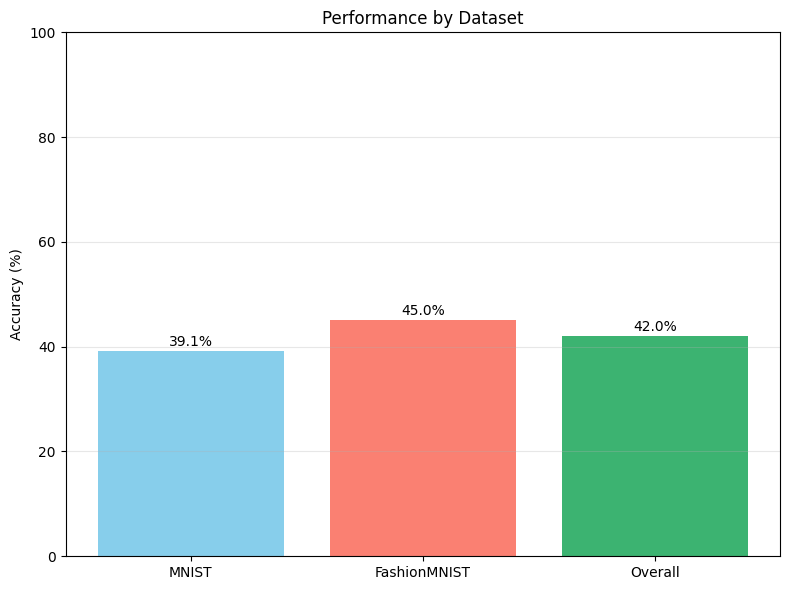

In [8]:
# Divide into MNIST and FashionMNIST sections
plt.figure(figsize=(8, 6))

datasets = ['MNIST', 'FashionMNIST', 'Overall']
accs = [mnist_acc, fashion_acc, checkpoint['val_acc']]
colors = ['skyblue', 'salmon', 'mediumseagreen']

plt.bar(datasets, accs, color=colors)
plt.ylabel('Accuracy (%)')
plt.title('Performance by Dataset')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(accs):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('dataset_comparison.png')
plt.show()


 ## Visualize Predictions

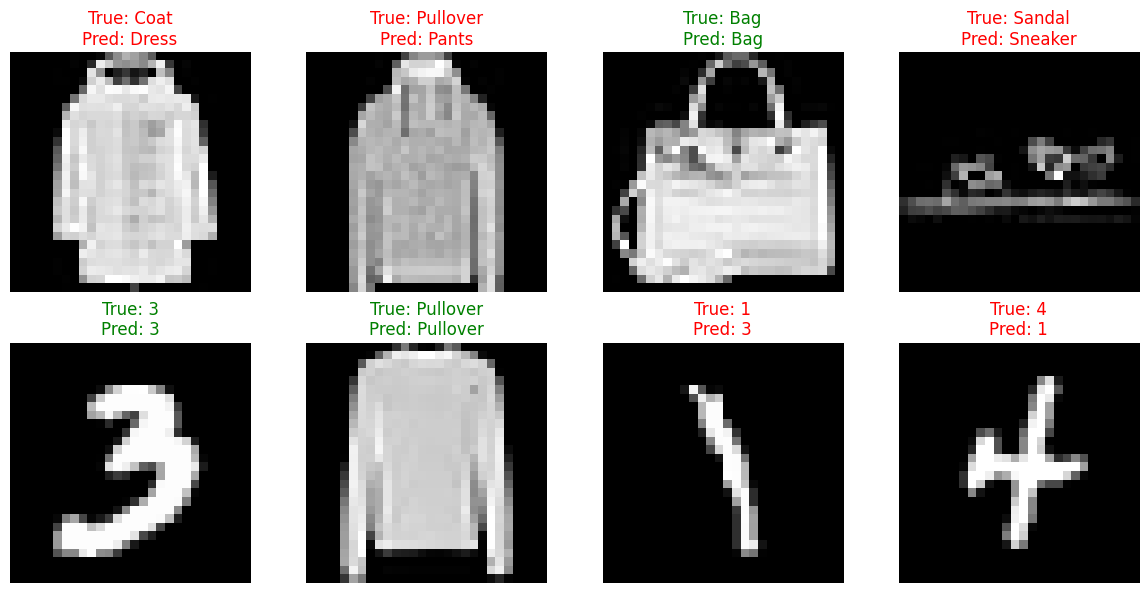

In [9]:
# Visualize model predictions
@torch.no_grad()
def visualize_predictions(model, dataset, n_samples=8, classes=None):
    model.eval()

    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    # Make predictions
    for i in range(n_samples):
        # Get random sample
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]

        # Predict
        img_tensor = img.unsqueeze(0).to(device)
        logits, _ = model(img_tensor)
        pred = logits.argmax(dim=1).item()

        # Display image
        img = img.squeeze().cpu().numpy()
        img = (img * 0.5) + 0.5  # Denormalize

        axes[i].imshow(img, cmap='gray')
        title_color = 'green' if pred == label else 'red'
        axes[i].set_title(f"True: {classes[label]}\nPred: {classes[pred]}",
                         color=title_color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()

# Visualize predictions
visualize_predictions(model, test_data, n_samples=8, classes=test_data.classes)